In [1]:

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
%matplotlib inline

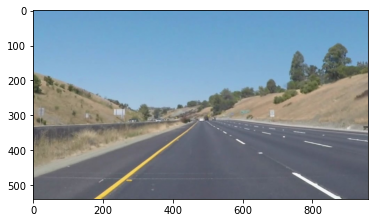

In [2]:
img = mpimg.imread('whiteCarLaneSwitch.jpg')
plt.imshow(img)

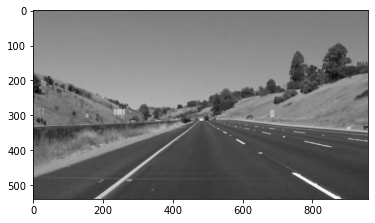

In [27]:
# get the gray scale image 
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')

In [4]:
img_height = img.shape[0]
img_width  = img.shape[1]
print("shape of the image is ",img.shape)
print("image height is ",img_height)
print("image width is ",img_width)

shape of the image is  (540, 960, 3)
image height is  540
image width is  960


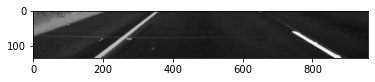

In [31]:
# img[cols,rows,third]
cropped_img = gray[int(0.75*img_height):img_height,:]

plt.imshow(cropped_img,cmap = 'gray')

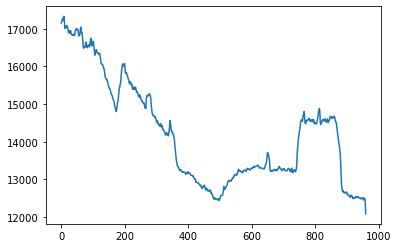

In [38]:
# get the sum of colums
# ie sumation[0] will be the sum of column 1
# ie sumation[1] will be the sum of column 2 
# ie sumation[959] will be the sum of last column  
sumation=np.sum(cropped_img,axis=0)

plt.plot(sumation)

shape of the image (135, 960)
[[134 131 131 ... 100 100 100]
 [132 129 130 ... 100 100 100]
 [130 126 128 ... 100 100 100]
 ...
 [ 99  98  98 ...  88  86  83]
 [ 98  98  97 ...  88  86  82]
 [ 96  95  95 ...  87  85  82]]


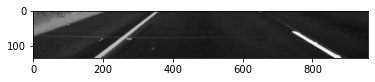

In [44]:
#stacking
print ("shape of the image",cropped_img.shape)
print (cropped_img)
plt.imshow(cropped_img,cmap = 'gray')

In [42]:
stacked_image = np.dstack((cropped_img,cropped_img))

In [43]:
print("stacked_image shape is ",stacked_image.shape)

stacked_image shape is  (135, 960, 2)


In [114]:
#creating a warped image 
def pipeline(img,threshold=(75,255)):
    
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    plt.title("Hue")
    plt.imshow(h_channel,cmap = 'gray')
    plt.show()
    
    plt.title("lightness")
    plt.imshow(l_channel,cmap = 'gray')
    plt.show()
    
    plt.title("saturation")
    plt.imshow(s_channel,cmap = 'gray')
    plt.show()
    
    # compining threshold over the channels that can detect lines correctly

    # applying threshold on Hue channel (this worked well for colored lane lines)
    binary_h = np.zeros_like(h_channel)
    binary_h[(h_channel>=0) & (h_channel<=50) ] =1
    plt.title("Binary Hue")
    plt.imshow(binary_h,cmap = 'gray')
    plt.show()
        
    # applying threshold on Lightness channel (i think this will work well under various lighting condition)
    
    binary_l = np.zeros_like(l_channel)
    binary_l[(l_channel>=175) & (l_channel<=255) ] =1   # i think lane line should be bright enough
    plt.title("Binary Lightness")
    plt.imshow(binary_l,cmap = 'gray')
    plt.show()    
    
    # applying threshold on saturation channel 
    binary_s = np.zeros_like(s_channel)
    
    binary_s[(s_channel > threshold[0]) & (s_channel< threshold[1])] = 1
    
    plt.title("Binary Saturation")
    plt.imshow(binary_s,cmap = 'gray')
    plt.show()
    
    
    # stack the image 
    colored_images = np.dstack((binary_h,binary_l,binary_s))*255

    plt.title("Binary color")
    plt.imshow(colored_images)
    plt.show()    
    
    
    # compined binaries
    binary_combined = np.zeros_like(binary_s)
    binary_combined[(binary_h == 1) | (binary_l ==1) | (binary_s==1)] = 1 
    
    plt.title("Binary combined")
    plt.imshow(binary_combined,cmap = 'gray')
    plt.show()        
    
    src = np.float32([[428,353],[549,349],[180,538],[875,539]])
    dst = np.float32([[420,91],[640,91],[415,537],[637,538]])
    
    # get the bird's eye view of the frame 
    M = cv2.getPerspectiveTransform(src, dst)
    warp = cv2.warpPerspective(binary_s, M, (img.shape[1], img.shape[0]))
    plt.title("Bird's eye view")
    plt.imshow(warp,cmap = 'gray')
    plt.show()    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warp[warp.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warp, warp, warp))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint      
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warp.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = warp.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Assuming we have `left_fit` and `right_fit` from `np.polyfit` before
    # Generate x and y values for plotting
    ploty = np.linspace(0, warp.shape[0]-1, warp.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)    

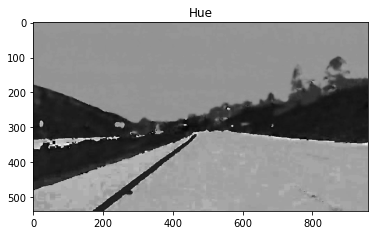

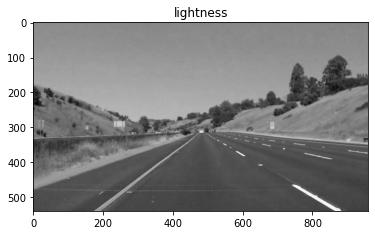

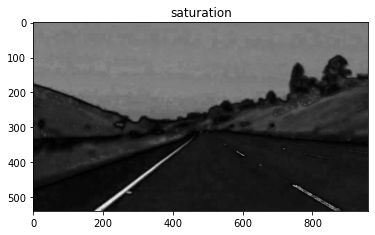

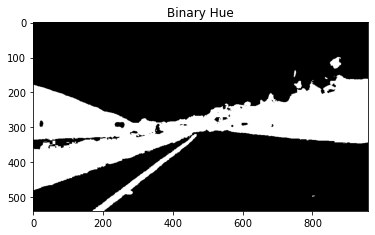

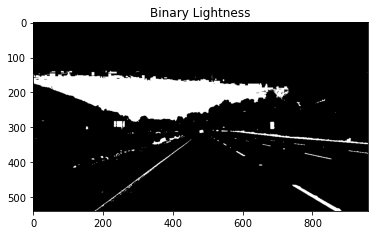

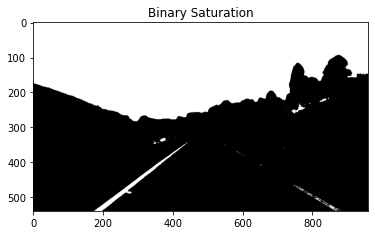

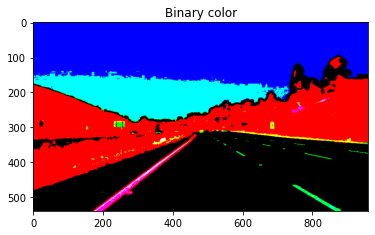

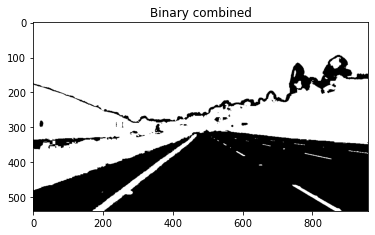

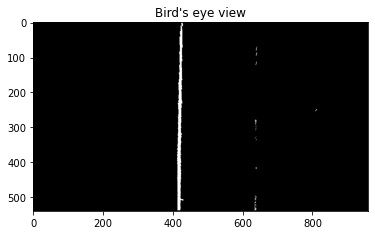

ValueError: need at least one array to concatenate

In [115]:
pipeline(img)